# Pricing Model

In [106]:
from google.colab import files

uploaded = files.upload()

Saving output_data.csv to output_data (4).csv


In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [108]:

data=pd.read_csv('output_data.csv')
data.head()


,mkt_id,output_date,output_own_price,output_own_cost,output_comp_price,output_own_profits,output_X,output_own_share,output_own_sales
0,44,01jan2019,7.05,5.90,7.11,15.065000,42.80,0.515267,13.10
1,44,02jan2019,7.05,6.05,7.11,24.310000,36.14,0.557082,24.31
2,44,03jan2019,7.05,5.98,7.28,30.783910,34.34,0.579922,28.77
3,44,04jan2019,7.05,5.98,7.28,20.169500,36.32,0.542767,18.85
4,44,05jan2019,6.79,6.07,6.68,1.231200,44.06,0.494757,1.71
...,...,...,...,...,...,...,...,...,...
19705,15555,27dec2019,7.28,5.96,7.30,26.070000,36.68,0.515118,19.75
19706,15555,28dec2019,6.69,5.94,6.64,3.720000,34.34,0.497312,4.96
19707,15555,29dec2019,6.69,5.91,6.64,3.393001,32.00,0.424593,4.35
19708,15555,30dec2019,7.31,5.99,7.42,31.561200,31.10,0.465712,23.91


In [109]:
def preprocess_data(data):
  data1 = data
  try : 
    
    d = {'jan':'-01-', 'feb':'-02-', 'mar': '-03-', 'apr':'-04-','may' : '-05-', 'jun' : '-06-', 'jul' : '-07-', 'aug' : '-08-', 'sep' : '-09-',
        'oct' : '-10-', 'nov' : '-11-', 'dec' : '-12-'}
    for old, new in d.items():
        data1['output_date'] = data1['output_date'].str.replace(old, new, regex=False)
    data1['output_date'] = pd.to_datetime(data1['output_date'],format = '%d-%m-%Y')
    data1['total_sales'] = data1['output_own_sales'] / data1['output_own_share']


  except : 
    pass 
  return data1

In [110]:
## split train and test data 

def split_data(data): 
  data = preprocess_data(data)
  train = pd.DataFrame()
  test = pd.DataFrame()
  validation = pd.DataFrame()
  for id in data['mkt_id'].unique().tolist():
    train = pd.concat([train, data[(data['mkt_id'] == id) & (data['output_date'] <= "2019-09-30")]]) 
    validation = pd.concat([validation,data[(data['mkt_id'] == id) & (data['output_date'] >= "2019-09-30")]]) 
    # test = pd.concat([test, data[(data['mkt_id'] == id) & (data['output_date'] >= "2019-12-01")]])

  return train, validation
train,validation = split_data(data)


In [111]:
### construct timeseries using lags
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % ('output_own_sales', i))]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [134]:
### def processing data function 
def process_data(df): 

  df = preprocess_data(df)



  ## For the first model 

  ### Train set 
  dff = df[['output_date', "output_own_sales"]]
  series = series_to_supervised(dff.drop('output_date', axis=1), window=10, lag=10)
  X1=series.drop('output_own_sales(t)',axis=1)
  X = df[10:].join(X1).drop(columns = ['mkt_id', 'output_date','output_own_cost','output_own_profits','output_own_share','output_own_sales','total_sales'])
  y1=series[['output_own_sales(t)']]


  ## For the second model


  return X,y1


X,y = process_data(validation)

X

,output_own_price,output_comp_price,output_X,output_own_sales(t-10),output_own_sales(t-9),output_own_sales(t-8),output_own_sales(t-7),output_own_sales(t-6),output_own_sales(t-5),output_own_sales(t-4),output_own_sales(t-3),output_own_sales(t-2),output_own_sales(t-1)
282,7.10,7.10,50.54,3.16,5.34,5.22,6.91,9.16,1.07,1.35,10.08,5.07,5.76
283,7.10,7.10,53.78,5.34,5.22,6.91,9.16,1.07,1.35,10.08,5.07,5.76,6.64
284,6.71,6.77,54.68,5.22,6.91,9.16,1.07,1.35,10.08,5.07,5.76,6.64,4.37
285,6.71,6.77,57.74,6.91,9.16,1.07,1.35,10.08,5.07,5.76,6.64,4.37,0.53
286,7.07,7.02,58.46,9.16,1.07,1.35,10.08,5.07,5.76,6.64,4.37,0.53,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19705,7.28,7.30,36.68,11.19,10.67,14.82,11.07,3.68,3.05,22.22,21.53,20.07,13.04
19706,6.69,6.64,34.34,10.67,14.82,11.07,3.68,3.05,22.22,21.53,20.07,13.04,19.75
19707,6.69,6.64,32.00,14.82,11.07,3.68,3.05,22.22,21.53,20.07,13.04,19.75,4.96
19708,7.31,7.42,31.10,11.07,3.68,3.05,22.22,21.53,20.07,13.04,19.75,4.96,4.35


In [135]:
data_example = preprocess_data(data[data['mkt_id'] == 44])[['output_date','output_own_sales']]
# data_example 

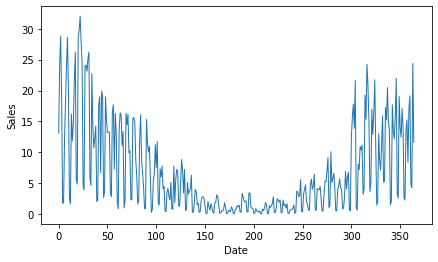

In [136]:
###daily sales for the year 2019

plt.figure(figsize=(7,4))
plt.plot(data_example.output_own_sales, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [143]:

X_train,Y_train = process_data(train[train['mkt_id'] == 44])
X_valid, Y_valid = process_data(validation[validation['mkt_id']== 44 ] )

# X_train

In [144]:
## Scaling The data 
scaler= MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [145]:
X_train_series = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])) 
X_valid_series = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (263, 1, 13)
Validation set shape (83, 1, 13)


In [175]:
## function to train the prediction model according to the chosen market 

def train_model(X_train_series, Y_train, X_valid_series, Y_valid) : 



  model_lstm = Sequential()
  model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
  model_lstm.add(Dropout(0.1)) #for better regularization
  model_lstm.add(Dense(1,activation='linear'))
  model_lstm.compile(loss='mse', optimizer='adam')
  print(model_lstm.summary()) 
  model_lstm.compile(optimizer='adam', loss='mse')
  lstm_history = model_lstm.fit(X_train_series, Y_train,
                              validation_data=(X_valid_series, Y_valid), epochs=300, verbose = 0)
  
  return lstm_history, model_lstm 

lstm_history, model_lstm_44 = train_model( X_train_series, Y_train, X_valid_series, Y_valid)


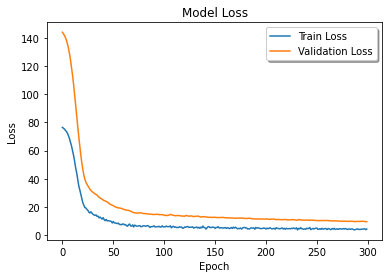

In [148]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], fancybox=True, shadow=True)
plt.show()

In [149]:
 # Predicting the sales
predicted_sales = model_lstm_44.predict(X_valid_series)
predicted_sales = predicted_sales.flatten()
Y_valid2=Y_valid.reset_index(drop=True)
# Y_valid2


3/3 [==============================] - 0s 3ms/step


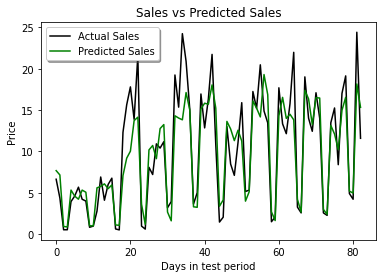

In [150]:
## plot the prediction and the actual values 

plt.plot(Y_valid2, color='black', label=f"Actual Sales")
plt.plot(predicted_sales, color= 'green', label="Predicted Sales")
plt.title("Sales vs Predicted Sales")
plt.xlabel("Days in test period")
plt.ylabel("Price")
plt.legend(fancybox=True, shadow=True)
plt.show()

In [155]:
X_valid, Y_valid = process_data(validation[validation['mkt_id']== 44 ] )
X_valid.reset_index()

,index,output_own_price,output_comp_price,output_X,output_own_sales(t-10),output_own_sales(t-9),output_own_sales(t-8),output_own_sales(t-7),output_own_sales(t-6),output_own_sales(t-5),output_own_sales(t-4),output_own_sales(t-3),output_own_sales(t-2),output_own_sales(t-1)
0,282,7.10,7.10,50.54,3.16,5.34,5.22,6.91,9.16,1.07,1.35,10.08,5.07,5.76
1,283,7.10,7.10,53.78,5.34,5.22,6.91,9.16,1.07,1.35,10.08,5.07,5.76,6.64
2,284,6.71,6.77,54.68,5.22,6.91,9.16,1.07,1.35,10.08,5.07,5.76,6.64,4.37
3,285,6.71,6.77,57.74,6.91,9.16,1.07,1.35,10.08,5.07,5.76,6.64,4.37,0.53
4,286,7.07,7.02,58.46,9.16,1.07,1.35,10.08,5.07,5.76,6.64,4.37,0.53,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,360,7.20,7.18,35.78,14.02,12.44,17.10,14.02,2.57,2.27,13.48,15.26,8.40,17.02
79,361,6.77,6.79,33.80,12.44,17.10,14.02,2.57,2.27,13.48,15.26,8.40,17.02,19.14
80,362,6.77,6.79,32.72,17.10,14.02,2.57,2.27,13.48,15.26,8.40,17.02,19.14,4.91
81,363,7.29,7.26,33.98,14.02,2.57,2.27,13.48,15.26,8.40,17.02,19.14,4.91,4.22


In [161]:
## this code is responsable of generating prices close to comp price to predict later the output sales for each price

def generate_examples(testt): 

  dfr = testt
  var = [-1,-2,-3,-4,-5,1,2,3,4,5]
  for e in var: 
    r = 1 + e /100 
    ndf = testt 
    ndf['output_own_price'] = ndf['output_comp_price'] * r

    dfr = pd.concat([dfr, ndf]).drop_duplicates()

  return dfr.sort_values(by=['output_comp_price','output_X'])


In [167]:
X_valid_series[:10].shape

(10, 1, 13)

In [189]:
## This function takes as parameters the market id, and the raw data, and returns the best price according to the criterea chosen

def predict_price(market_id , data ):
  df = preprocess_data(data)

  train, validation = split_data(df)

  X_train,Y_train = process_data(train[train['mkt_id'] == market_id])
  X_valid, Y_valid = process_data(validation[validation['mkt_id']== market_id ] )

  X_valid_gen = generate_examples(X_valid)

  ## Scaling The data 
  scaler= MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_valid = scaler.transform(X_valid)
  X_valid_gen_scaled = scaler.transform(X_valid_gen)

  X_train_series = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])) 
  X_valid_series = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
  X_valid_gen_series = X_valid_gen_scaled.reshape((X_valid_gen_scaled.shape[0], 1, X_valid_gen_scaled.shape[1]))


  ## Training the model for the choosen market
  lstm_history, lstm_model = train_model(X_train_series, Y_train, X_valid_series, Y_valid)

  for i in range(len(X_valid)):

    day = X_valid_gen_series[10*i:10*(i+1)]

    ## predict global sales 
    predicted_sale = lstm_model.predict(day)
    predicted_sale = predicted_sale.flatten()
    
  
    ## choose the best price according to optimization 

    prices = np.array(X_valid_gen['output_own_price'][10*i:10*(i+1)])
    costs = np.array([validation.iloc[i]['output_own_cost']]*10)
    obj = predicted_sale * (prices - costs)
    best_price = prices[np.argmax(obj)]

    print(f"The best price found for the day {validation.iloc[i]['output_date']} is {best_price}  ")

    

predict_price(44,data)




Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 50)                12800     
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12,851
Trainable params: 12,851
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 0s 123ms/step
The best price found for the day 2019-09-30 00:00:00 is 6.9719999999999995  
1/1 [==============================] - 0s 15ms/step
The best price found for the day 2019-10-01 00:00:00 is 6.9719999999999995  
1/1 [==============================] - 0s 13ms/st